# Pyatoa
#### Python's Adjoint Tomography Operations Assistant

`Pyatoa` is a misfit quantification toolbox for the modern tomographer. It provides abstraction over key Python packages to facilitate data gathering, preprocessing, misfit analysis and visualization in a seismic tomography problem. The design of `Pyatoa` was inspired by `Obspy`, translating to a design ethos of rapid development, through scripting or shell interaction, and useful abstractions to accomplish tasks in tomography.

The source code of `Pyatoa` can be found here: https://github.com/bch0w/pyatoa


---

`Pyatoa` is built around a handful of Python packages:


[Obspy:](https://github.com/obspy/obspy/wiki) for seismic data fetching, handling, processing and organization.   
[Pyflex:](https://krischer.github.io/pyflex/) a Python port of Flexwin, an automatic time window selection algorithm.   
[Pyadjoint:](http://krischer.github.io/pyadjoint/) a package for calculating misfit and creating adjoint sources.   
[PyASDF:](https://seismicdata.github.io/pyasdf/) heirarchical data storage for seismic data.  
[Matplotlib:](https://matplotlib.org/) 2D plotting library for visualization of waveforms, statistics, misfit etc  
[Basemap:](https://matplotlib.org/basemap/) A mapping library for source receiver distributions, raypaths, etc. (deprecated, Cartopy in the future).  


---

## Installation 
Pyatoa is still currently under development so a package manager install has not been implemented.  
Install will have to be through the Github repository:
```bash
$ git clone https://github.com/bch0w/pyatoa.git
$ cd pyatoa
$ python setup.py install
```

---

## Tutorial 1: core classes; general workflow
Here we provide a brief introduction on how `Pyatoa` is intended to be used standalone.  
`Pyatoa` is normally very quiet to avoid unnecessary outputs, however it really babbles on about everything.  
We can use the `logging` module to see what's going on under the hood.

In [45]:
%pylab inline
import obspy
import pyatoa
import logging

logger = logging.getLogger("pyatoa")
logger.setLevel(logging.DEBUG)

Populating the interactive namespace from numpy and matplotlib


### pyatoa.Config()
`Pyatoa` is centralized around a `Config` object which controls all the parameters deemed necessary in the misfit quantification workflow. The `Config` object supports print statements to tell the User what parameters are available, and how they are set.

In [46]:
cfg = pyatoa.Config()
print(cfg)

CONFIG
	model_number:            None
	event_id:                None
	min_period:              10.0
	max_period:              30.0
	filter_corners:          4.0
	client:                  GEONET
	rotate_to_rtz:           False
	unit_output:             DISP
	synthetic_unit:          DISP
	observed_tag:            observed
	synthetic_tag:           synthetic
	pyflex_map:              default
	adj_src_type:            cc_traveltime_misfit
	map_corners:             None
	synthetics_only:         False
	window_amplitude_ratio:  0.0
	zero_pad:                0
	start_pad:               20
	end_pad:                 500
	component_list:          ['Z', 'N', 'E']
	cfgpaths:                {'waveforms': [], 'synthetics': [], 'responses': []}
	pyflex_config:           <pyflex.config.Config object at 0x119d15588>
	pyadjoint_config:        <pyadjoint.config.Config object at 0x119d15828>



We can see here that we have some default parameters set, e.g. the filter bands `min_period` and `max_period`, as well as configurations for the `pyflex_map` which specifies the parameters of the `pyflex_config`. We also can set the `adj_src_type` which controls the parameters of the `pyadjoint_config`. For now we will ignore the rest of the parameters and move onto the `Manager` class. 

### pyatoa.Manager()
The `Manager` class always requires a `Config` input parameter. Printing the `Manager` shows us the `Pyatoa` data and workflow status.

In [47]:
mgmt = pyatoa.Manager(cfg)
print(mgmt)

DATA
	dataset (ds):                 None
	event:                        None
	moment tensor (half_dur):     0
	inventory (inv):              None
	observed data (st_obs):       0
	synthetic data (st_syn):      0
WORKFLOW
	standardized:                 False
	st_obs filtered:              False
	st_syn filtered:              False
	misfit windows (windows):     0
	misfit (adj_srcs):            0.00E+00



We can see above that we have no data collected and our workflow is incomplete. Although `Pyatoa` comes with data gathering capabilities, for this example we will just read in some test data. We will see that once we set the data in the Manager class, the print statement updates to show us how many Traces we have in our Streams, and the name of the station in our inventory object.

In [61]:
mgmt.inv = obspy.read_inventory("../tests/data/test_inv.xml")
mgmt.st_obs = obspy.read("../tests/data/test_obs_data.ascii")
mgmt.st_syn = obspy.read("../tests/data/test_syn_m00_data.ascii")
print(f"OBSSERVED DATA\n\tsampling_rate:{mgmt.st_obs[0].stats.sampling_rate}, npts:{mgmt.st_obs[0].stats.npts}\n")
print(f"SYNTHETIC DATA\n\tsampling_rate:{mgmt.st_syn[0].stats.sampling_rate}, npts:{mgmt.st_syn[0].stats.npts}\n")
print(mgmt)

OBSSERVED DATA
	sampling_rate:100.0, npts:52001

SYNTHETIC DATA
	sampling_rate:125.0, npts:30000

DATA
	dataset (ds):                 None
	event:                        smi:nz.org.geonet/2018p130600
	moment tensor (half_dur):     0
	inventory (inv):              NZ.BFZ
	observed data (st_obs):       3
	synthetic data (st_syn):      3
WORKFLOW
	standardized:                 False
	st_obs filtered:              False
	st_syn filtered:              False
	misfit windows (windows):     0
	misfit (adj_srcs):            0.00E+00



We now have the minimum data required to begin the workflow. However, we cannot create misfit windows or measure misfit yet, because our traces have different sampling rates, start and end-times, and spectral content. If we try to run the window() and measure() functions, we will be met with some check-stops telling us that we must first run other functions.

In [5]:
mgmt.window()
mgmt.measure()

[2019-12-21 12:37:35,756] - pyatoa - WARNING: cannot window, waveforms not standardized
[2019-12-21 12:37:35,758] - pyatoa - WARNING: cannot measure misfit, traces not standardized


### Data processing

The first step after gathering data is to standardize Streams. standardize() will resample and trim the data so that sampling rate, number of points, and start and end times are the same between the Observed and Synthetic traces. Data by default should conform to Synthetics, due to the requirements of a solver to receive inputs in the same manner as its outputs, but running `mgmt.standardize(standardize_to='obs')` allows the User to override this.

In [62]:
mgmt.standardize()

[2019-12-21 17:12:39,346] - pyatoa - INFO: standardizing streams
[2019-12-21 17:12:39,442] - pyatoa - DEBUG: time offset set to -0.155s


In [50]:
mgmt.preprocess()

[2019-12-21 17:08:40,773] - pyatoa - INFO: preprocessing observation data
[2019-12-21 17:08:40,919] - pyatoa - DEBUG: remove response, units of DISP
[2019-12-21 17:08:40,937] - pyatoa - DEBUG: filter 10.0s to 30.0s
[2019-12-21 17:08:40,938] - pyatoa - INFO: preprocessing synthetic data
[2019-12-21 17:08:40,965] - pyatoa - DEBUG: filter 10.0s to 30.0s
[2019-12-21 17:08:40,968] - pyatoa - INFO: moment tensor not found for event, cannot convolve


In [63]:
print(mgmt.st)

6 Trace(s) in Stream:
NZ.BFZ..HXE   | 2018-02-18T07:43:47.972644Z - 2018-02-18T07:47:47.964644Z | 125.0 Hz, 30000 samples
NZ.BFZ..HXN   | 2018-02-18T07:43:47.972644Z - 2018-02-18T07:47:47.964644Z | 125.0 Hz, 30000 samples
NZ.BFZ..HXZ   | 2018-02-18T07:43:47.972644Z - 2018-02-18T07:47:47.964644Z | 125.0 Hz, 30000 samples
NZ.BFZ.10.HHE | 2018-02-18T07:43:47.976394Z - 2018-02-18T07:47:47.968394Z | 125.0 Hz, 30000 samples
NZ.BFZ.10.HHN | 2018-02-18T07:43:47.976394Z - 2018-02-18T07:47:47.968394Z | 125.0 Hz, 30000 samples
NZ.BFZ.10.HHZ | 2018-02-18T07:43:47.976394Z - 2018-02-18T07:47:47.968394Z | 125.0 Hz, 30000 samples


We can now see that after performing standardization and preprocessing, 3 of the workflow flags have been set `True`, which means we can move onto the the window() and measure() functions. Standardization and preprocessing are done in place, which means the original data is not retrievable. Accessing `mgmt.st_obs` returns the processed data.

### Misfit Quantification

Now that the data has been processed, we can run our misfit quantification:

In [52]:
mgmt.window()
mgmt.measure()

[2019-12-21 17:08:44,369] - pyatoa - INFO: running Pyflex w/ map: default
[2019-12-21 17:08:44,444] - pyflex - WARNING: No rejection based on traveltime possible. Event and/or station information is not available.
/Users/Chow/miniconda3/envs/tomo/lib/python3.7/site-packages/pyasdf/asdf_data_set.py:52: PyflexWarning: No rejection based on traveltime possible. Event and/or station information is not available.
  closure_warn(self, *args, **kwargs)
[2019-12-21 17:08:44,449] - pyflex - WARNING: Cannot calculate the end of the noise as event and/or station information is not given and thus the theoretical arrival times cannot be calculated
[2019-12-21 17:08:44,454] - pyflex - WARNING: Cannot reject windows based on their signal to noise ratio. Please give station and event information or information about the temporal range of the noise.
[2019-12-21 17:08:44,535] - pyatoa - INFO: 0 window(s) for comp Z
[2019-12-21 17:08:44,590] - pyflex - WARNING: No rejection based on traveltime possible. 

`Pyatoa` has run `Pyflex` and recovered 1 window for the traces, which is saved into the Manager as a dictionary. It has then run `Pyadjoint` to measure the misfit on the recovered windows from `Pyflex`. We can take a look at the `windows` and `adj_srcs` to see that they are saved as dictionaries following the `Config.component_list`. Each entry of the `windows` dictionary is a list of `Window` objects from `Pyflex`. Each entry of the `adj_srcs` is an AdjointSource object from `Pyadjoint`.

In [30]:
print(f"Windows:\n{mgmt.windows}\n")
print(f"Adjoint Sources:\n{mgmt.adj_srcs}\n")
print(f"Adjoint Source Object:\n{mgmt.adj_srcs['E']}\n")
print(f"Adjoint Source Data:\n{mgmt.adj_srcs['E'].adjoint_source}")

Windows:
{'E': [Window(left=1649, right=9765, center=5707, channel_id=NZ.BFZ.10.HHE, max_cc_value=0.8385478628040428, cc_shift=54, dlnA=-0.8993776279578864)]}

Adjoint Sources:
{'E': <pyadjoint.adjoint_source.AdjointSource object at 0x1168e8cc0>}

Adjoint Source Object:
Cross Correlation Traveltime Misfit Adjoint Source for component HHE at station NZ.BFZ
    Misfit: 0.1793
    Adjoint source available with 30000 samples

Adjoint Source Data:
[0. 0. 0. ... 0. 0. 0.]


### Plotting, mapping

Plot functionalities will plot the available streams in the Manager class. If windows and adjoint sources are available for a given component, they will also be plotted alongside the waveform data. Kwargs can be passed to the plot function to change the default look of the waveform plots. Information about the chosen misfit windows, such as the time shift between Observed and Synthetic traces, will be annotated into each window.

Mapping capabilities are also available. The mapping function will try to include as much information as possible. In this case since we have not included an Event in our Manager class, the mapper will only be able to plot the station. Additionally, as we have not specified any map corners, the Map will be plotted for the whole Earth.

[2019-12-21 12:45:54,424] - pyatoa - INFO: plotting waveform


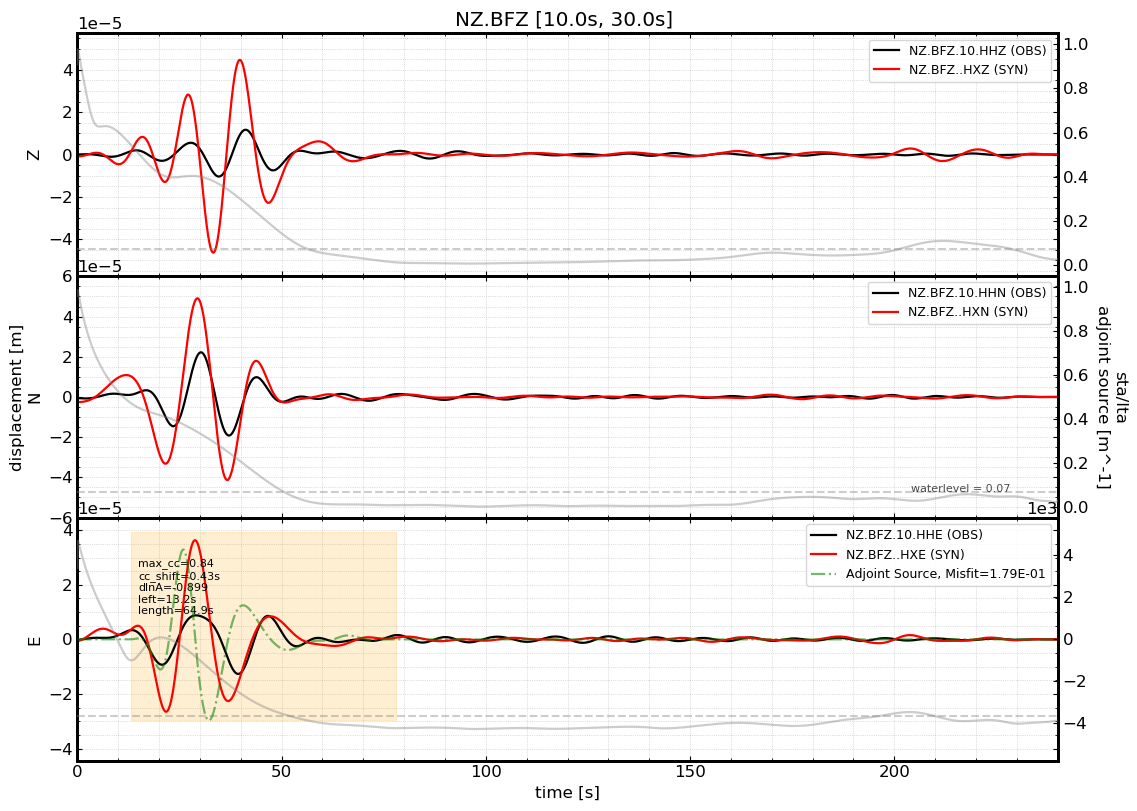

In [34]:
mgmt.plot()

## Tutorial 2: custom configs for Pyflex and Pyadjoint
Config objects are written for both [Pyflex](https://krischer.github.io/pyflex/_modules/pyflex/config.html) and [Pyadjoint](https://github.com/krischer/pyadjoint/blob/master/src/pyadjoint/config.py) so that the User could fine tune their misfit measurement criteria. For simplicitiy, these Config classes have been wrapped into the Pyatoa Config class, either through map names or key word arguments. We can take a look at the default settings by printing the Config class.

In [43]:
from pprint import pprint
cfg = pyatoa.Config()
print(f"Pyflex Config Map: {cfg.pyflex_map}")
pprint(vars(cfg.pyflex_config))

print('\n')
print(f"Pyadjoint Config: {cfg.adj_src_type}")
pprint(vars(cfg.pyadjoint_config))

Pyflex Config Map: default
{'c_0': 1.0,
 'c_1': 1.5,
 'c_2': 0.0,
 'c_3a': 4.0,
 'c_3b': 2.5,
 'c_4a': 2.0,
 'c_4b': 6.0,
 'cc_acceptance_level': 0.7,
 'check_global_data_quality': False,
 'dlna_acceptance_level': 1.3,
 'dlna_reference': 0.0,
 'earth_model': 'ak135',
 'max_period': 30.0,
 'max_time_before_first_arrival': 50.0,
 'min_period': 10.0,
 'min_surface_wave_velocity': 3.0,
 'noise_end_index': None,
 'noise_start_index': 0,
 'resolution_strategy': 'interval_scheduling',
 's2n_limit': 1.5,
 'signal_end_index': None,
 'signal_start_index': 0,
 'snr_integrate_base': 3.5,
 'snr_max_base': 3.0,
 'stalta_waterlevel': 0.07,
 'tshift_acceptance_level': 10.0,
 'tshift_reference': 0.0,
 'window_signal_to_noise_type': 'amplitude',
 'window_weight_fct': None}


Pyadjoint Config: cc_traveltime_misfit
{'dlna_sigma_min': 0.5,
 'dt_fac': 2.0,
 'dt_max_scale': 3.5,
 'dt_sigma_min': 1.0,
 'err_fac': 2.5,
 'ipower_costaper': 8,
 'lnpt': 15,
 'max_period': 30.0,
 'measure_type': 'dt',
 'min_cycle_

### Pyflex Config
To override the default parameters of the Pyflex Config, two options are given. 

1) hardcode the source-code of Pyatoa to include a preset Config map in pyatoa/plugins/pyflex_config.set_pyflex_config(). There we have already set three pre-set maps, "example", "alaska" and "hikurangi". Users may define their own custom choices and map names. 

2) pass keyword arguments through the Pyatoa Config. These are then passed to the Pyflex Config if matching attributes are found. 

Below we show examples of both types of overwriting. For simplicity we just look at the Pyflex Config parameter `c_0` to see how this works.

In [72]:
cfg = pyatoa.Config()
print(f'Default c_0: {cfg.pyflex_config.c_0}')
cfg = pyatoa.Config(pyflex_map="incorrect_map_names_will_set_the_pyflex_config_to_default")
print(f'Incorrect map name, no kwargs c_0: {cfg.pyflex_config.c_0}')
cfg = pyatoa.Config(pyflex_map="hikurangi")
print(f'Option 1, preset map c_0: {cfg.pyflex_config.c_0}')
cfg = pyatoa.Config(pyflex_map=None, c_0=2.0)
print(f'Option 2, kwargs c_0: {cfg.pyflex_config.c_0}')

Default c_0: 1.0
Incorrect map name, no kwargs c_0: 1.0
Option 1, preset map c_0: 0.7
Option 2, kwargs c_0: 2.0


### Pyadjoint Config
To overwrite the default Config parameters of pyadjoint, kwargs may be passed through the Pyatoa `Config` class to overwrite the default Pyadjoint Config parameters. Here we show examples for the `phase_step` parameter in the 
pyadjoint.Config() class. 

Note: Adjoint source types must also be passed to the Config parameter. Pyadjoint allows custom adjoint source types, so there are no checks for correctly specified `adj_src_type`. Attempting to run Manager.measure() with an undefined `adj_src_type` will lead to errors from Pyadjoint.

In [71]:
cfg = pyatoa.Config()
print(f'Default adj_src_type: {cfg.adj_src_type}')
cfg = pyatoa.Config(adj_src_type="custom_adj_src_type")
print(f'Custom adj_src_type: {cfg.adj_src_type}')
print(f'Default phase_step: {cfg.pyadjoint_config.phase_step}')
cfg = pyatoa.Config(phase_step=3)
print(f'Kwargs phase_step: {cfg.pyadjoint_config.phase_step}')

Default adj_src_type: cc_traveltime_misfit
Custom adj_src_type: custom_adj_src_type
Default phase_step: 1.5
Kwargs phase_step: 3


## Tutoral 3: dynamic data gathering

Pyatoa allows for dynamic data gathering based on its mid-level `Gatherer` class which calls on the low-level `Getter` and `Fetcher` classes. These are all wrapped up in the `Manager` class so that the User does not need to interact with the lower levels. 

When data gathering, `Manager` always seeks the path of least resistance; that is, the `Manager` will always search for data internally (either via a given Pyasdf Dataset, or through directory structures), before moving on to more costly external searches which use FDSN to query webservices. We can see an example of this in the following code.

Note: Data is fetched based on event origintime information. 

##### Internal Fetching

To get the `Manager` to search internal pathways, paths must be given in the proper format.
1) Observed data must be saved based on SEED observatory convention, that is in a specific directory structure with specific file naming, following the format:

`/path/to/waveforms/YEAR/NETWORK/STATION/CHANNEL/NN.SSS.LL.CCC.D.YYYY.DDD`  
for example  
`/path/to/waveforms/2018/NZ/BFZ/HHZ.D/NZ.BFZ.10.HHZ.D.2018.049`

2) Synthetic data should be placed in a directory, with the convention  
`path/to/synthetics/NN.SSS.CCC.sem?`

In [91]:
import logging
from pyatoa import Config, Manager

logger = logging.getLogger("pyatoa")
logger.setLevel(logging.DEBUG)

cfg = Config(event_id="2018p130600",
             cfgpaths={"waveforms":"../tests/data/test_directories/waveforms",
                       "synthetics":"../tests/data/test_directories/synthetics"}
            )
mgmt = Manager(cfg)
mgmt.gather(station_code="NZ.BFZ.??.HH?", choice=["st_obs", "st_syn"])
print(mgmt)

[2019-12-21 14:54:59,862] - pyatoa - INFO: initiating/resetting gatherer
[2019-12-21 14:54:59,866] - pyatoa - DEBUG: fetching event from GEONET
[2019-12-21 14:55:00,604] - pyatoa - INFO: geonet moment tensor external for event: 2018p130600
[2019-12-21 14:55:00,605] - pyatoa - INFO: appending GeoNet moment tensor information to event
[2019-12-21 14:55:00,606] - pyatoa - DEBUG: event got from external
[2019-12-21 14:55:00,607] - pyatoa - INFO: gathering NZ.BFZ.??.HH? for 2018p130600
[2019-12-21 14:55:00,608] - pyatoa - DEBUG: gathering observation waveforms
[2019-12-21 14:55:00,687] - pyatoa - DEBUG: stream fetched from directory ../tests/data/test_directories/waveforms/2018/NZ/BFZ/HHZ.D/NZ.BFZ.10.HHZ.D.2018.049
[2019-12-21 14:55:00,758] - pyatoa - DEBUG: stream fetched from directory ../tests/data/test_directories/waveforms/2018/NZ/BFZ/HHE.D/NZ.BFZ.10.HHE.D.2018.049
[2019-12-21 14:55:00,830] - pyatoa - DEBUG: stream fetched from directory ../tests/data/test_directories/waveforms/2018/NZ

DATA
	dataset (ds):                 None
	event:                        smi:nz.org.geonet/2018p130600
	moment tensor (half_dur):     0
	inventory (inv):              None
	observed data (st_obs):       3
	synthetic data (st_syn):      3
WORKFLOW
	standardized:                 False
	st_obs filtered:              False
	st_syn filtered:              False
	misfit windows (windows):     0
	misfit (adj_srcs):            0.00E+00



##### External Getting

We can see that we have collected data from the given directories. Since data gathering happens using event origin times, the Event must be gathered before the data. If no paths are given in the `Config.cfgpaths` parameter, and no pyasdf.ASDFDataSet is assigned to the `Manager`, then the Gatherer will query the FDSN webservice in order to download data. This has been tested with New Zealand's GeoNet FDSN client, and IRIS' FDSN client, however not with other webservices, although no problems are expected. 

##### Moment Tensors

The Gatherer will also try to fetch moment tensor information. So far this only works for GeoNet and IRIS events. For GeoNet events, the github repository containing John Ristau's moment tensors will be read in and appended. For IRIS events, GCMT will be queried for moment tensor information.

In [96]:
mgmt = Manager(Config(event_id="2018p130600", client="GEONET"))
mgmt.gather('NZ.BFZ.??.HH?', choice=["inv", "st_obs"])
print(mgmt)

[2019-12-21 15:22:36,452] - pyatoa - INFO: initiating/resetting gatherer
[2019-12-21 15:22:36,457] - pyatoa - DEBUG: fetching event from GEONET
[2019-12-21 15:22:37,133] - pyatoa - INFO: geonet moment tensor external for event: 2018p130600
[2019-12-21 15:22:37,134] - pyatoa - INFO: appending GeoNet moment tensor information to event
[2019-12-21 15:22:37,135] - pyatoa - DEBUG: event got from external
[2019-12-21 15:22:37,136] - pyatoa - INFO: gathering NZ.BFZ.??.HH? for 2018p130600
[2019-12-21 15:22:37,137] - pyatoa - DEBUG: gathering station information
[2019-12-21 15:22:37,138] - pyatoa - DEBUG: no response found for given paths
[2019-12-21 15:22:37,139] - pyatoa - DEBUG: internal station information not found, searching ext.
[2019-12-21 15:22:37,140] - pyatoa - DEBUG: fetching station from GEONET
[2019-12-21 15:22:37,210] - pyatoa - DEBUG: gathering observation waveforms
[2019-12-21 15:22:37,211] - pyatoa - DEBUG: no waveforms found for NZ.BFZ.??.HH? for given directories
[2019-12-21

DATA
	dataset (ds):                 None
	event:                        smi:nz.org.geonet/2018p130600
	moment tensor (half_dur):     0
	inventory (inv):              NZ.BFZ
	observed data (st_obs):       3
	synthetic data (st_syn):      0
WORKFLOW
	standardized:                 False
	st_obs filtered:              False
	st_syn filtered:              False
	misfit windows (windows):     0
	misfit (adj_srcs):            0.00E+00



In [115]:
# e.g. we can look at the 2018-01-23 Mww7.9 Gulf Of Alaska event,
# recorded at the Black Forest Observatory in Germany
mgmt = Manager(pyatoa.Config(event_id="10607586", client="IRIS"))
mgmt.gather("II.ERM.00.BHZ")
print(mgmt)
mgmt.st_obs.plot()

[2019-12-21 15:38:00,424] - pyatoa - INFO: initiating/resetting gatherer
[2019-12-21 15:38:00,428] - pyatoa - DEBUG: fetching event from IRIS
[2019-12-21 15:38:00,523] - pyatoa - INFO: querying GCMT database for moment tensor
[2019-12-21 15:38:01,509] - pyatoa - INFO: gcmt event found matching criteria
[2019-12-21 15:38:01,518] - pyatoa - DEBUG: event got from external
[2019-12-21 15:38:01,519] - pyatoa - INFO: gathering II.ERM.00.BHZ for 10607586
[2019-12-21 15:38:01,519] - pyatoa - DEBUG: gathering station information
[2019-12-21 15:38:01,521] - pyatoa - DEBUG: no response found for given paths
[2019-12-21 15:38:01,522] - pyatoa - DEBUG: internal station information not found, searching ext.
[2019-12-21 15:38:01,523] - pyatoa - DEBUG: fetching station from IRIS
[2019-12-21 15:38:01,633] - pyatoa - DEBUG: gathering observation waveforms
[2019-12-21 15:38:01,633] - pyatoa - DEBUG: no waveforms found for II.ERM.00.BHZ for given directories
[2019-12-21 15:38:01,634] - pyatoa - DEBUG: int


DATA
	dataset (ds):                 None
	event:                        smi:local/ndk/C201801230931A/event
	moment tensor (half_dur):     0
	inventory (inv):              II.ERM
	observed data (st_obs):       1
	synthetic data (st_syn):      0
WORKFLOW
	standardized:                 False
	st_obs filtered:              False
	st_syn filtered:              False
	misfit windows (windows):     0
	misfit (adj_srcs):            0.00E+00



## Tutorial 4: interacting with pyasdf

Pyasdf datasets are HDF5 datasets that allow for heirarchical storage of seismic data. It provides a very clean and compact way to store all the data that is collected during this workflow, including raw seismic waveforms, event and response information, misfit window and adjoint source information. To enable saving to a Pyasdf Dataset, you simply need to set your target dataset as an input when calling the `Manager` class.

In [4]:
import pyasdf
import logging
from pyatoa import Config, Manager

logger = logging.getLogger("pyatoa")
logger.setLevel(logging.DEBUG)

ds = pyasdf.ASDFDataSet("test_dataset.h5")

cfg = Config(event_id="2018p130600", client="GEONET", 
             cfgpaths={"synthetics":"../tests/data/test_directories/synthetics",
                       "waveforms":"../tests/data/test_directories/waveforms"}
             )
cfg.write(write_to=ds)
mgmt = Manager(cfg, ds=ds)
mgmt.gather("NZ.BFZ.??.HH?")
print(mgmt)

[2019-12-21 17:46:54,465] - pyatoa - INFO: initiating/resetting gatherer
/Users/Chow/miniconda3/envs/tomo/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
[2019-12-21 17:46:54,903] - pyatoa - INFO: gathering NZ.BFZ.??.HH? for 2018p130600
[2019-12-21 17:46:54,904] - pyatoa - DEBUG: gathering station information
[2019-12-21 17:46:54,904] - pyatoa - DEBUG: searching station internal asdf
[2019-12-21 17:46:54,914] - pyatoa - DEBUG: gathering observation waveforms
[2019-12-21 17:46:54,915] - pyatoa - DEBUG: fetching obs internal asdf
[2019-12-21 17:46:54,939] - pyatoa - DEBUG: gathering synthetic waveforms
[2019-12-21 17:46:54,941] - pyatoa - DEBUG: fetching syn internal asdf


DATA
	dataset (ds):                 None
	event:                        smi:nz.org.geonet/2018p130600
	moment tensor (half_dur):     0
	inventory (inv):              NZ.BFZ
	observed data (st_obs):       3
	synthetic data (st_syn):      3
WORKFLOW
	standardized:                 False
	st_obs filtered:              False
	st_syn filtered:              False
	misfit windows (windows):     0
	misfit (adj_srcs):            0.00E+00



In [5]:
print(f"DATASET:\n{ds}\n\n"
      f"EVENTS:\n{ds.events}\n\n"
      f"STATION:\n{ds.waveforms['NZ.BFZ']}\n\n"
      f"INVENTORY:\n{ds.waveforms['NZ.BFZ'].StationXML}\n\n"
      f"WAVEFORMS:\n{ds.waveforms['NZ.BFZ']['observed']}"
     )


DATASET:
ASDF file [format version: 1.0.2]: 'test_dataset.h5' (1.0 MB)
	Contains 1 event(s)
	Contains waveform data from 1 station(s).

EVENTS:
1 Event(s) in Catalog:
2018-02-18T07:43:48.127644Z | -39.949, +176.300 | 5.156706293 M  | manual

STATION:
Contents of the data set for station NZ.BFZ:
    - Has a StationXML file
    - 2 Waveform Tag(s):
        observed
        synthetic

INVENTORY:
Inventory created at 2019-12-20T04:48:30.000000Z
	Created by: Delta
		    None
	Sending institution: GeoNet (WEL(GNS_Test))
	Contains:
		Networks (1):
			NZ
		Stations (1):
			NZ.BFZ (Birch Farm)
		Channels (3):
			NZ.BFZ.10.HHZ, NZ.BFZ.10.HHN, NZ.BFZ.10.HHE

WAVEFORMS:
3 Trace(s) in Stream:
NZ.BFZ.10.HHE | 2018-02-18T07:43:28.128394Z - 2018-02-18T07:52:08.128394Z | 100.0 Hz, 52001 samples
NZ.BFZ.10.HHN | 2018-02-18T07:43:28.128394Z - 2018-02-18T07:52:08.128394Z | 100.0 Hz, 52001 samples
NZ.BFZ.10.HHZ | 2018-02-18T07:43:28.128394Z - 2018-02-18T07:52:08.128394Z | 100.0 Hz, 52001 samples


In [6]:
mgmt.standardize()
mgmt.preprocess()
mgmt.window()
mgmt.measure()

[2019-12-21 17:47:23,093] - pyatoa - INFO: standardizing streams
[2019-12-21 17:47:23,208] - pyatoa - DEBUG: time offset set to -0.0775s
[2019-12-21 17:47:23,209] - pyatoa - INFO: preprocessing observation data
[2019-12-21 17:47:23,357] - pyatoa - DEBUG: remove response, units of DISP
[2019-12-21 17:47:23,379] - pyatoa - DEBUG: filter 10.0s to 30.0s
[2019-12-21 17:47:23,381] - pyatoa - INFO: preprocessing synthetic data
[2019-12-21 17:47:23,404] - pyatoa - DEBUG: filter 10.0s to 30.0s
[2019-12-21 17:47:23,406] - pyatoa - DEBUG: convolve w/ gaussian half-dur=0.70s
[2019-12-21 17:47:23,415] - pyatoa - INFO: running Pyflex w/ map: default
[2019-12-21 17:47:23,692] - pyatoa - INFO: 0 window(s) for comp Z
[2019-12-21 17:47:23,942] - pyatoa - INFO: 0 window(s) for comp N
[2019-12-21 17:47:24,202] - pyatoa - INFO: 1 window(s) for comp E
[2019-12-21 17:47:24,203] - pyatoa - DEBUG: saving misfit windows to PyASDF
[2019-12-21 17:47:24,212] - pyatoa - INFO: 1 window(s) total found
[2019-12-21 17:

In [21]:
print(f"AUX DATA:\n{ds.auxiliary_data}\n\n"
      f"WINDOWS:\n{ds.auxiliary_data.MisfitWindows['None'].NZ_BFZ_E_0}\n\n"
      f"ADJOINT SOURCES:\n{ds.auxiliary_data.AdjointSources['None'].NZ_BFZ_HXE}"
     )


AUX DATA:
Data set contains the following auxiliary data types:
	AdjointSources (1 item(s))
	MisfitWindows (1 item(s))

WINDOWS:
Auxiliary Data of Type 'MisfitWindows'
	Path: 'None/NZ_BFZ_E_0'
	Data shape: '(1,)', dtype: 'bool'
	Parameters:
		absolute_endtime: 2018-02-18T07:44:45.210144Z
		absolute_starttime: 2018-02-18T07:44:01.250144Z
		cc_shift_in_samples: 43
		cc_shift_in_seconds: 0.34400000000000003
		center_index: 4397
		channel_id: NZ.BFZ.10.HHE
		dlnA: -0.8990262679871982
		dt: 0.008
		left_index: 1650
		max_cc_value: 0.84104863069917
		min_period: 10.0
		phase_arrival_P: 15.262626335461087
		phase_arrival_Pn: 15.131893962613248
		phase_arrival_S: 25.701646985505022
		phase_arrival_Sn: 25.67509457717087
		phase_arrival_p: 14.046040658280816
		phase_arrival_s: 23.621667003141294
		phase_arrival_sP: 18.780030497780345
		relative_endtime: 57.160000000000004
		relative_starttime: 13.200000000000001
		right_index: 7145
		time_of_first_sample: 2018-02-18T07:43:48.050144Z
		window_wei

## Tutorial 6: visualization

To be written

## Tutorial 7: export to Specfem3D

To be written

## Tutorial 8: plugin to Seisflows

To be written

## Tutorial 9: misfit statistics

To be written